
# **An Observation on Topic Evolution of News with Word Clouds**

## **Main Settings**
Feel free to change the settings here.

### The date range of the data
format: month/day/year

In [ ]:
start_date = '1/1/2012'
end_date = '4/30/2022'

### Time scale to group the data by 

In [ ]:
# year, month_year, date
grp_by = 'year'

## **Web Scraping**


In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from tqdm import tqdm

### The main scraping function (The New York Times)
Choose the news titles and summaries from *Today’s Paper* as the data, seperate the front page news (headlines?) and the others for further comparison. Connect the texts from the same date with a space.

In [ ]:
def scrap(start_date, end_date):
  url_prefix = "www.nytimes.com/issue/todayspaper/"
  url_postfix = "/todays-new-york-times"

  # The news before 2017/12/12 are in The New York Times Web Archive
  # This may change in the future
  date_before_archive = pd.to_datetime('12/12/2017')
  url_archive_prefix = "archive.nytimes.com/www.nytimes.com/indexes/"
  url_archive_postfix = "/todayspaper/index.html"
  
  # The style of the page changed since 2010/10/25
  date_style_changed = pd.to_datetime("10/25/2010")

  # I can't find the news before 2006/04/01, skip them for now
  # This may change in the future
  date_before_NF = pd.to_datetime('04/01/2006')

  front_pages_list = []
  other_pages_list = []

  # Go through the date range
  daterange = pd.date_range(start_date, end_date)
  for single_date in tqdm(daterange):
    date = single_date.strftime("%Y/%m/%d")
    
    # Skip if this page can't be found
    if single_date < date_before_NF:
      continue

    # Check if the news in the web archive
    url = "https://"
    if single_date < date_before_archive:
      url = url + url_archive_prefix + date + url_archive_postfix
    else:
      url = url + url_prefix + date + url_postfix

    # Get webpage HTML
    result = requests.get(url)
    doc = BeautifulSoup(result.text, "html.parser")

    # Filter the target content
    front_pages = []
    other_pages = []

    # The style in archive or not is different
    if single_date < date_before_archive:
      if single_date < date_style_changed:
        # The front page
        front_pages.extend(doc.select("div.clearfix > h5 > a"))
        front_pages.extend(doc.select("div.clearfix > p.summary"))
        # Others
        other_pages.extend(doc.select("div.headline > a"))

      else:
        # The front page
        front_pages.extend(doc.select("div.story > h3 > a"))
        front_pages.extend(doc.select("div.story > p.summary"))
        # Others
        other_pages.extend(doc.select("ul.headlinesOnly > li > h6 > a"))

    else:
      # The front page
      front_pages.extend(doc.find_all("h2", "css-byk1jx"))
      front_pages.extend(doc.find_all("p", "css-tskdi9"))
      # Others
      other_pages.extend(doc.find_all("h2", "css-ds6ff4"))
      other_pages.extend(doc.find_all("p", "css-1fomug7"))
    
    # May throw error if the selected content contains no texts, which means the selection is not good enough
    front_pages_texts = ' '.join([t.text.strip() for t in front_pages])
    other_pages_texts = ' '.join([t.text.strip() for t in other_pages])

    # A weird thing is that ' became &apos instead of &apos; in many news before 2015, we need to replace them manually
    front_pages_texts = front_pages_texts.replace('&apos', '\'')
    other_pages_texts = other_pages_texts.replace('&apos', '\'')

    front_pages_list.append(front_pages_texts)
    other_pages_list.append(other_pages_texts)
  
  # Create DataFrame
  df = pd.DataFrame(list(zip(daterange, front_pages_list, other_pages_list)), columns=['date', 'front_page', 'other_page'])
  df['all_page'] = df['front_page'] + ' ' + df['other_page']
  
  return df

### **Let's Go!**
This may take time, do something else while waiting!

In [ ]:
df = scrap(start_date, end_date)
df

100%|██████████| 3773/3773 [1:14:39<00:00,  1.19s/it]


,date,front_page,other_page,all_page
0,2012-01-01,Obama to Turn Up Attacks on Congress in Campai...,"In Tsunami Aftermath, ‘Road to Future’ Unsettl...",Obama to Turn Up Attacks on Congress in Campai...
1,2012-01-02,Romney Fights for First-Place Showing in Iowa ...,Memo From Moscow: A Dilemma for Russian Leader...,Romney Fights for First-Place Showing in Iowa ...
2,2012-01-03,Panetta to Offer Strategy for Cutting Military...,Opposition Protests Constitution in Hungary Eu...,Panetta to Offer Strategy for Cutting Military...
3,2012-01-04,Romney Wins Iowa Caucus by 8 Votes First Vote ...,Erbil Journal: Iraq’s Factional Chaos Threaten...,Romney Wins Iowa Caucus by 8 Votes First Vote ...
4,2012-01-05,Romney Takes a Victory Lap as Santorum Plays C...,Work as Usual for U.S. Warship After Warning b...,Romney Takes a Victory Lap as Santorum Plays C...
...,...,...,...,...
3768,2022-04-26,"Emboldened by Ukraine’s Grit, U.S. Wants to Se...",Judge Holds Trump in Contempt Over Documents i...,"Emboldened by Ukraine’s Grit, U.S. Wants to Se..."
3769,2022-04-27,"As Diplomacy Hopes Dim, U.S. Marshals Allies t...","‘I Just Want to Help’: Amid Chaos, Shanghai Re...","As Diplomacy Hopes Dim, U.S. Marshals Allies t..."
3770,2022-04-28,Ukraine War Impact Widens: Russia Cuts Gas Flo...,"The Driver, the Officer and the Deadly Traffic...",Ukraine War Impact Widens: Russia Cuts Gas Flo...
3771,2022-04-29,"Biden Digs In on Ukraine Strategy, Seeking $33...",G.O.P. Concocts Fake Threat: Voter Fraud by Un...,"Biden Digs In on Ukraine Strategy, Seeking $33..."


### Save the data

In [ ]:
df.to_csv("nytimes_data.csv", encoding='utf-8', index=False)

## **Data Exploration**

### (Optional) Load the prepared data
Start from here if you have prepared your data and don't need to do the scraping.

In [ ]:
# import pandas as pd
# from tqdm import tqdm
# df = pd.read_csv('nytimes_data.csv')

### Pre-processing
Lemmatization didn't go well (e.g. died->dy), so I decided not to use it.

In [ ]:
import nltk
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(df, col_name):
  ignore = set(nltk.corpus.stopwords.words("english"))
  ignore.update(list(string.punctuation))

  corpus = []
  for i in tqdm(range(0, df.shape[0])):
      # Make all lowercase to filter stopwords
      text = df[col_name][i].lower()

      # Tokenize while keeping abbreviations and hyphenated words
      # ref: https://stackoverflow.com/questions/55201299/word-tokenization-nltk-abbreviation-problem
      pattern = r'''(?x)          # set flag to allow verbose regexps
          (?:[A-Za-z]\.)+        # abbreviations(both upper and lower case, like "e.g.", "U.S.A.")
          | \w+(?:-\w+)*        # words with optional internal hyphens 
          | [][.,;"'?():_`-]      # these are separate tokens; includes ], [
      '''
      text = nltk.regexp_tokenize(text, pattern)

      # Ignore stop words and punctuations
      text = [word for word in text if not word in ignore]
      text = " ".join(text)
      
      # Make all uppercase for result showing
      text = text.upper()
      corpus.append(text)
      
  return corpus

In [ ]:
df['processed_front_page'] = preprocess(df, 'front_page')
df['processed_other_page'] = preprocess(df, 'other_page')
df['processed_all_page'] = preprocess(df, 'all_page')

100%|██████████| 3773/3773 [00:03<00:00, 1250.92it/s]


In [ ]:
# Split Year and Month data for convenience
df['month_year'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.to_period('Y')

### Group the data to the time scale set above
Connect the texts in the same group with a space.

In [ ]:
aggregation_functions = {'processed_front_page': ' '.join, 'processed_other_page': ' '.join, 'processed_all_page': ' '.join}
df_new = df[[grp_by, 'processed_front_page', 'processed_other_page', 'processed_all_page']].groupby(grp_by).agg(aggregation_functions).reset_index()
df_new

,year,processed_front_page,processed_other_page,processed_all_page
0,2012,OBAMA TURN ATTACKS CONGRESS CAMPAIGN F.D.A. FI...,TSUNAMI AFTERMATH ROAD FUTURE UNSETTLES VILLAG...,OBAMA TURN ATTACKS CONGRESS CAMPAIGN F.D.A. FI...
1,2013,TENTATIVE DEAL REACHED RAISE TAXES WEALTHY GRA...,IRAN TESTS NEW VERSION MISSILES EXERCISE VIOLE...,TENTATIVE DEAL REACHED RAISE TAXES WEALTHY GRA...
2,2014,DE BLASIO DRAWS LIBERAL EYES NEW YORK CITY POW...,KERRY PRESS FRAMEWORK ACCORD KEEP MIDEAST PEAC...,DE BLASIO DRAWS LIBERAL EYES NEW YORK CITY POW...
3,2015,PALESTINIANS SET SEEK REDRESS WORLD COURT CRAS...,AIRASIA CHIEF RESPONDS QUICKLY COMPASSION ANTI...,PALESTINIANS SET SEEK REDRESS WORLD COURT CRAS...
4,2016,RESPONSE PARIS ATTACKS POINTS WEAKNESSES FRENC...,FLOODING MISSOURI RAISES VEXING QUESTIONS F.B....,RESPONSE PARIS ATTACKS POINTS WEAKNESSES FRENC...
5,2017,OBAMA LAST DAYS AIDING TRUMP TRANSITION ERECTI...,DAMAGED WAR SYRIA CULTURAL SITES RISE ANEW FRA...,OBAMA LAST DAYS AIDING TRUMP TRANSITION ERECTI...
6,2018,PARTISANS WIELDING MONEY BEGIN SEEKING EXPLOIT...,WALL LOVE OUTSIDE JAIL COLORADO GUNMAN SHOOTS ...,PARTISANS WIELDING MONEY BEGIN SEEKING EXPLOIT...
7,2019,ELIZABETH WARREN ANNOUNCES IOWA TRIP STARTS RU...,WIELDING ROCKS KNIVES ARIZONANS ATTACK SELF-DR...,ELIZABETH WARREN ANNOUNCES IOWA TRIP STARTS RU...
8,2020,PROTESTERS ATTACK U.S. EMBASSY IRAQ CHANTING D...,F.D.A. PLANS BAN E-CIGARETTE FLAVORS MENTHOL B...,PROTESTERS ATTACK U.S. EMBASSY IRAQ CHANTING D...
9,2021,DISTRIBUTION VACCINE TAKING LONGER EXPECTED TR...,NEW YORKERS REMEMBER YEAR WAIT FORGET SASSE SL...,DISTRIBUTION VACCINE TAKING LONGER EXPECTED TR...


### Word Cloud
It seems abbreviations and hyphenated words can't be kept for now, need to be improved.

In [ ]:
from wordcloud import WordCloud
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

def make_wordcloud(df, col_name):
  for i in range(0, df_new.shape[0]):
    wordcloud = WordCloud(
                background_color='white',
                width=1600,
                height=800,
                random_state=42
                ).generate(df[col_name][i])
    # Bigger image
    # plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(df_new[grp_by][i], fontsize=20)
    plt.show()

    # Save the image
    Path(f"wordcloud/{col_name}/").mkdir(parents=True, exist_ok=True)
    wordcloud.to_file(f"wordcloud/{col_name}/{df[grp_by][i]}_{col_name}.png")

#### All pages

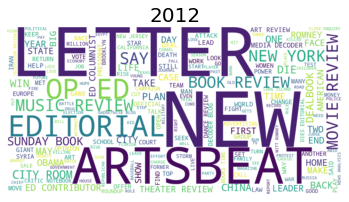

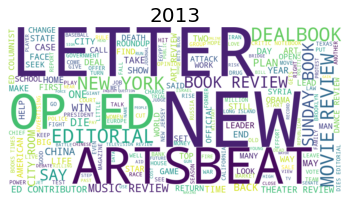

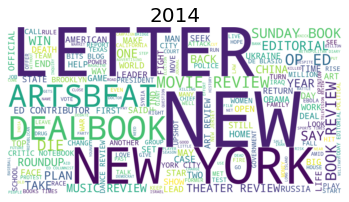

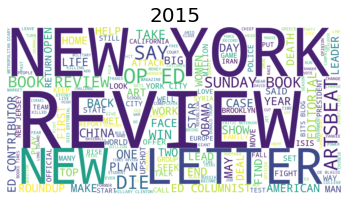

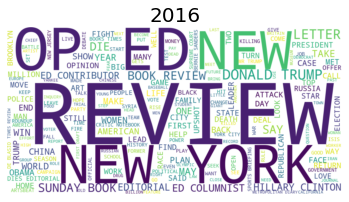

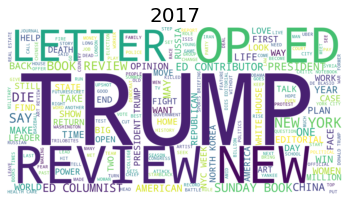

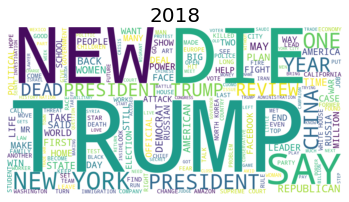

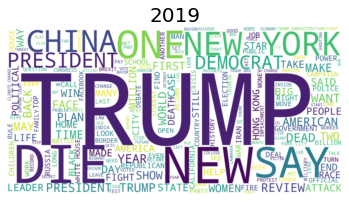

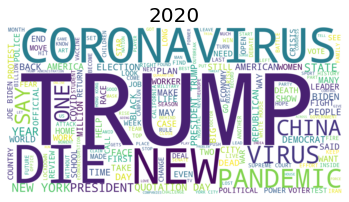

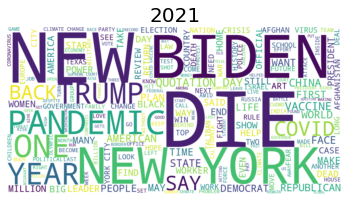

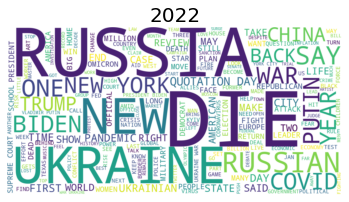

In [ ]:
make_wordcloud(df_new, 'processed_all_page')

#### Only Front Pages

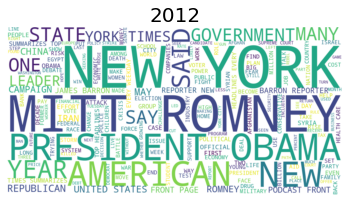

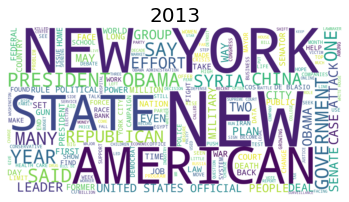

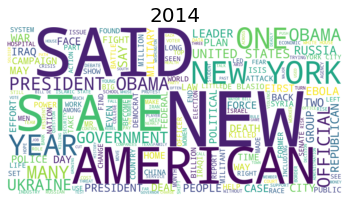

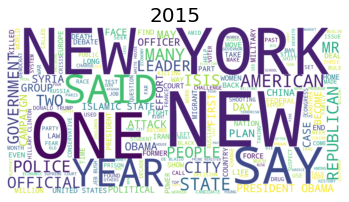

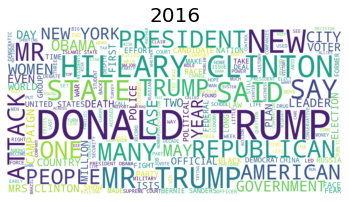

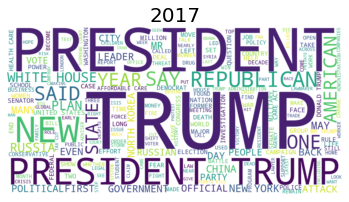

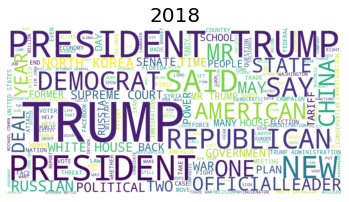

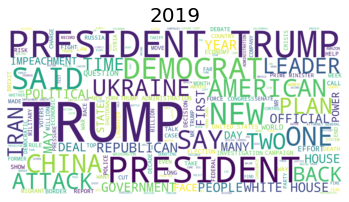

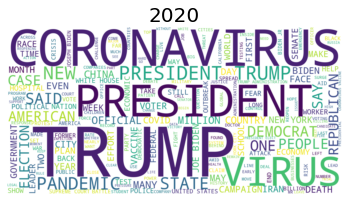

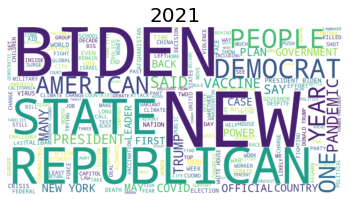

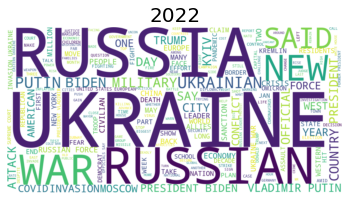

In [ ]:
make_wordcloud(df_new, 'processed_front_page')

#### (Optional) Download the Word Cloud images from Google Colab

In [ ]:
# from google.colab import files
# !tar -czvf "wordcloud.tar.gz" "wordcloud"
# files.download("wordcloud.tar.gz")

wordcloud/
wordcloud/processed_front_page/
wordcloud/processed_front_page/2012_processed_front_page.png
wordcloud/processed_front_page/2017_processed_front_page.png
wordcloud/processed_front_page/2014_processed_front_page.png
wordcloud/processed_front_page/2013_processed_front_page.png
wordcloud/processed_front_page/2015_processed_front_page.png
wordcloud/processed_front_page/2021_processed_front_page.png
wordcloud/processed_front_page/2020_processed_front_page.png
wordcloud/processed_front_page/2016_processed_front_page.png
wordcloud/processed_front_page/2022_processed_front_page.png
wordcloud/processed_front_page/2019_processed_front_page.png
wordcloud/processed_front_page/2018_processed_front_page.png
wordcloud/processed_all_page/
wordcloud/processed_all_page/2020_processed_all_page.png
wordcloud/processed_all_page/2013_processed_all_page.png
wordcloud/processed_all_page/2015_processed_all_page.png
wordcloud/processed_all_page/2019_processed_all_page.png
wordcloud/processed_all_page

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>